In [54]:
# import proplot as pplt
import numpy as np
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob
import dask.array as da
from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [55]:
# Import observational data from CRUTEM5
dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [56]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
# display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.roll(lon=len(tas_CRUTEMP.lon)//2, roll_coords=True)
tas_CRUTEMP['lon'] = np.where(tas_CRUTEMP['lon']> 180, tas_CRUTEMP['lon']-360, tas_CRUTEMP['lon'])
print(tas_CRUTEMP)

tas_MLOST = tas_MLOST.roll(lon=len(tas_MLOST.lon)//2, roll_coords=True)
tas_MLOST['lon'] = np.where(tas_MLOST['lon']> 180, tas_MLOST['lon']-360, tas_MLOST['lon'])
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2078, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:      

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 -0.1569 -0.1569 -0.1418 ... 5.342 5.45
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [57]:
tas_CRUTEMP['tas']=tas_CRUTEMP['tas']-273.15
tas_GISS['air']=tas_GISS['air']-273.15
tas_MLOST['air']=tas_MLOST['air']-273.15
tas_CRUTEMP['tas'].attrs['units']='degC'
tas_GISS['air'].attrs['units']='degC'
tas_MLOST['air'].attrs['units']='degC'

In [58]:
tas_CRUTEMP['tas']
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 -273.3 -273.3 -273.3 ... -267.8 -267.7
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [59]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 91)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -273.3 -273.3 -273.3 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [60]:
tas_GISS_data    = tas_GISS['air'].loc['1950-01-01':'2014-12-01',0:90,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_data = tas_CRUTEMP['tas'].loc['1950-01-01':'2014-12-01',0:90,:]
tas_MLOST_data   = masked_tas['air'].loc['1950-01-01':'2014-12-01',0:90,:]

tas_GISS_ano     = tas_GISS_data-tas_GISS_data.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_data-tas_CRUTEMP_data.mean()
tas_MLOST_ano    = tas_MLOST_data-tas_MLOST_data.mean()

In [61]:
tas_MLOST_ano.min()

<xarray.DataArray 'air' ()>
array(-15.00061035)

In [62]:
#Calculate the annual mean anomalies
tas_GISS_annual    = tas_GISS_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_annual = tas_CRUTEMP_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_annual   = tas_MLOST_ano.mean(['lat','lon']).groupby('time.year').mean()

In [63]:
#Calculate the summertime anomalies
tas_GISS_JJA     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([6,7,8])]
tas_CRUTEMP_JJA  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([6,7,8])]
tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]

#calculate the wintertime anomalies
tas_GISS_DJF     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([12,1,2])].loc['1950-12-01':'2014-03-01']
tas_CRUTEMP_DJF  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([12,1,2])].loc['1950-12-01':'2014-03-01']
tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1950-12-01':'2014-03-01']
tas_MLOST_DJF

<xarray.DataArray 'air' (time: 192, lat: 45, lon: 91)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1951-01-01 ... 2014-02-01
  * lon      (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0

In [64]:
tas_GISS_JJA_mean = tas_GISS_JJA.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_JJA_mean = tas_CRUTEMP_JJA.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_JJA_mean = tas_MLOST_JJA.mean(['lat','lon']).groupby('time.year').mean()

tas_GISS_DJF_mean = tas_GISS_DJF.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_DJF_mean = tas_CRUTEMP_DJF.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_DJF_mean = tas_MLOST_DJF.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_DJF_mean.min()

<xarray.DataArray 'air' ()>
array(-2.53385997)

In [65]:
# calculate the trend
import statsmodels.api as sm

tas_GISS_annual_65yr = tas_GISS_annual.to_dataframe()
tas_CRUTEMP_annual_65yr = tas_CRUTEMP_annual.to_dataframe()
tas_MLOST_annual_65yr = tas_MLOST_annual.to_dataframe()
print(tas_MLOST_annual_65yr)

trend_GISS_annual = tas_GISS_annual_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_annual = tas_CRUTEMP_annual_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0  
    )

trend_MLOST_annual = tas_MLOST_annual_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_annual=trend_CRUTEMP_annual*len(tas_CRUTEMP_annual)
trend_MLOST_annual=trend_MLOST_annual*len(tas_MLOST_annual)
trend_GISS_annual=trend_GISS_annual*len(tas_GISS_annual)
trend_GISS_annual,trend_MLOST_annual

           air
year          
1950 -0.726234
1951 -0.280546
1952 -0.772274
1953 -0.074118
1954 -0.569925
...        ...
2010  0.709632
2011  0.943440
2012  0.710736
2013  0.952071
2014  0.851018

[65 rows x 1 columns]


(air    1.527472
 dtype: float64,
 air    1.660696
 dtype: float64)

In [66]:
tas_GISS_JJA_65yr = tas_GISS_JJA_mean.to_dataframe()
tas_CRUTEMP_JJA_65yr = tas_CRUTEMP_JJA_mean.to_dataframe()
tas_MLOST_JJA_65yr = tas_MLOST_JJA_mean.to_dataframe()
# print(tas_MLOST_JJA_65yr)

trend_GISS_JJA = tas_GISS_JJA_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_JJA = tas_CRUTEMP_JJA_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0  
    )

trend_MLOST_JJA = tas_MLOST_JJA_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_JJA=trend_CRUTEMP_JJA*len(tas_CRUTEMP_JJA_mean)
trend_MLOST_JJA=trend_MLOST_JJA*len(tas_MLOST_JJA_mean)
trend_GISS_JJA=trend_GISS_JJA*len(tas_GISS_JJA_mean)
trend_GISS_JJA,trend_MLOST_JJA, type(trend_MLOST_JJA)

(air    1.241747
 dtype: float64,
 air    1.296173
 dtype: float64,
 pandas.core.series.Series)

In [67]:
tas_GISS_DJF_65yr = tas_GISS_DJF_mean.to_dataframe()
tas_CRUTEMP_DJF_65yr = tas_CRUTEMP_DJF_mean.to_dataframe()
tas_MLOST_DJF_65yr = tas_MLOST_DJF_mean.to_dataframe()
# print(tas_MLOST_DJF_65yr)

trend_GISS_DJF = tas_GISS_DJF_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_DJF = tas_CRUTEMP_DJF_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0  
    )

trend_MLOST_DJF = tas_MLOST_DJF_65yr.apply(lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )

trend_CRUTEMP_DJF=trend_CRUTEMP_DJF*len(tas_CRUTEMP_DJF_mean)
trend_MLOST_DJF=trend_MLOST_DJF*len(tas_MLOST_DJF_mean)
trend_GISS_DJF=trend_GISS_DJF*len(tas_GISS_DJF_mean)
trend_GISS_DJF,trend_MLOST_DJF

(air    1.619357
 dtype: float64,
 air    1.545339
 dtype: float64)

In [68]:
ds = xr.open_mfdataset('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_MPI*.nc', combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 1980, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 1980, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [69]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_model_data = land_sea_mask['var1']
mask_model_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_model_data['time'].values, format='mixed', dayfirst=True)
mask_model_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_model_data = mask_model_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_model_tas = ds.where(mask_model_data == 1, drop=False)

# Print the resulting masked dataset
masked_model_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (run: 30, time: 1980, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 1980, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [70]:
nh_tas =  masked_model_tas['tas'].loc[:,'1900-01-01':'2014-12-31',0:90,:]#masked_tas.sel(time=slice('1900-01-01','2014-12-01'),lat=slice(0, 90))
nh_tas = nh_tas - 273.15
nh_tas_climatology = nh_tas.groupby('time.month').mean(dim='time')
tas_ano = nh_tas.groupby('time.month') - nh_tas_climatology
# tas_ano = nh_tas - nh_tas.mean()
print(tas_ano)
lat = tas_ano['lat']
lon = tas_ano['lon']

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 115 times more chunks
  return self.array[key]


<xarray.DataArray 'tas' (run: 30, time: 1380, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1380, 45, 180), dtype=float32, chunksize=(1, 1, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


In [71]:
tas_ano

<xarray.DataArray 'tas' (run: 30, time: 1380, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1380, 45, 180), dtype=float32, chunksize=(1, 1, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [72]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1900-01-16 12:00:00', '1900-02-15 00:00:00',
               '1900-03-16 12:00:00', '1900-04-16 00:00:00',
               '1900-05-16 12:00:00', '1900-06-16 00:00:00',
               '1900-07-16 12:00:00', '1900-08-16 12:00:00',
               '1900-09-16 00:00:00', '1900-10-16 12:00:00',
               ...
               '2014-03-16 12:00:00', '2014-04-16 00:00:00',
               '2014-05-16 12:00:00', '2014-06-16 00:00:00',
               '2014-07-16 12:00:00', '2014-08-16 12:00:00',
               '2014-09-16 00:00:00', '2014-10-16 12:00:00',
               '2014-11-16 00:00:00', '2014-12-16 12:00:00'],
              dtype='datetime64[ns]', length=1380, freq=None)

In [73]:
# for month in time_index.month.unique():
#     month_data = tas_ano.sel(time=time_index.month==month)
#     output_file_path= f"/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_{month}.nc"
#     month_data.to_netcdf(output_file_path)

In [74]:
weights = np.cos(np.deg2rad(tas_ano.lat))*xr.ones_like(tas_ano['lon'])
weights

<xarray.DataArray (lat: 45, lon: 180)>
array([[0.9998477 , 0.9998477 , 0.9998477 , ..., 0.9998477 , 0.9998477 ,
        0.9998477 ],
       [0.99862953, 0.99862953, 0.99862953, ..., 0.99862953, 0.99862953,
        0.99862953],
       [0.9961947 , 0.9961947 , 0.9961947 , ..., 0.9961947 , 0.9961947 ,
        0.9961947 ],
       ...,
       [0.08715574, 0.08715574, 0.08715574, ..., 0.08715574, 0.08715574,
        0.08715574],
       [0.05233596, 0.05233596, 0.05233596, ..., 0.05233596, 0.05233596,
        0.05233596],
       [0.01745241, 0.01745241, 0.01745241, ..., 0.01745241, 0.01745241,
        0.01745241]])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [75]:
#calculate the annual mean of the SAT
# weights = np.cos(np.deg2rad(tas_ano.lat))
# weights.name = "weights"
# weights

tas_ano_weighted = tas_ano.sel(lat=slice(0,90)).weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])/ weights.mean(dim=['lat', 'lon'])
tas_ano_weighted_mean

<xarray.DataArray (run: 30, time: 1380)>
dask.array<truediv, shape=(30, 1380), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [76]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# type(tas_ano_annual)
# display(tas_ano_annual.min().values)
# tas_ano_annual.max().values
new_dims = {
    'run': range(1, 31),
    'year': range(1900, 2015),
}

# Create the new DataArray with the reshaped data and proper dimensions and coordinates
# annual_tas_mean = xr.DataArray(annual_tas_mean, dims=('run', 'year'), coords=new_dims)

# Assign year as datetime values
Annual_tas_mean = tas_ano_annual.assign_coords(year=pd.to_datetime(tas_ano_annual.year, format='%Y'))

Annual_tas_mean

<xarray.DataArray (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1900-01-01 1901-01-01 ... 2014-01-01

In [77]:
Annual_mean_15yr = Annual_tas_mean.sel(year=Annual_tas_mean.year.dt.year.isin(np.arange(1950, 2015,1)))
Annual_mean_15yr

<xarray.DataArray (run: 30, year: 65)>
dask.array<getitem, shape=(30, 65), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1950-01-01 1951-01-01 ... 2014-01-01

In [78]:
import statsmodels.api as sm

# Convert the index to a DatetimeIndex
#df.index = pd.to_datetime(df.index, format="'(Timestamp('%Y-%m-%d %H:%M:%S'))'")

df_annual = Annual_mean_15yr.to_dataframe('trends')
df_annual.loc[(1,)]
runs_annual_trends = []
for run in range(1, 31):
    run_annual_data = df_annual.loc[(run,)] # Select data for the current run
    trend_annual = run_annual_data.apply(
        lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )
    # print(trend_annual)
    runs_annual_trends.append(trend_annual)

type(runs_annual_trends)
# Combine the monthly trends into a single DataFrame
trends_annual_df = pd.concat(runs_annual_trends, axis=1, keys=range(1, 31))
# Convert the list of trends into a DataArray with proper dimensions and coordinates
trends_annual_df.shape

(1, 30)

In [79]:
type(trends_annual_df)

pandas.core.frame.DataFrame

In [80]:
# Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
# Create the dimensions and coordinates for the DataArray
dims = ['time', 'run']
coords = {'time': range(0,1), 'run': range(1, 31)}

# Convert the DataFrame to a DataArray with specific dimensions and coordinates
trends_annual_da = xr.DataArray(
    trends_annual_df.values,
    dims=dims,
    coords=coords
)

# Set the attributes of the trend DataArray
trends_annual_da.attrs = Annual_mean_15yr.attrs

# Print the shape of the DataArray
print(trends_annual_da.shape)

trends_annual_da = trends_annual_da*65.0
trends_annual_da

(1, 30)


<xarray.DataArray (time: 1, run: 30)>
array([[2.01278235, 1.72807013, 2.01131567, 2.06887461, 1.91298583,
        1.92210635, 2.00211202, 1.92861737, 2.03661044, 2.32230562,
        1.82637266, 2.19242059, 1.82355888, 2.0006543 , 1.87768018,
        1.76871798, 2.07849618, 2.31416048, 1.66630787, 2.17255595,
        2.07495335, 1.72785837, 2.11287854, 2.2789735 , 2.24477401,
        2.10637275, 1.66368047, 2.1537197 , 2.12574222, 1.89795931]])
Coordinates:
  * time     (time) int64 0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

In [81]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas_ano.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear annual mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

<xarray.DataArray (run: 30, time: 345)>
dask.array<truediv, shape=(30, 345), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-06-16 ... 2014-08-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
    month    (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 6 ... 6 7 8 6 7 8 6 7 8 6 7 8

In [82]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
# JJA_tas_mean[0,:].values
JJA_tas_mean
type(JJA_tas_mean)

xarray.core.dataarray.DataArray

In [83]:
# Create the new dimensions and coordinates
new_dims = {
    'run': range(1, 31),
    'year': range(1900, 2015),
}

# Create the new DataArray with the reshaped data and proper dimensions and coordinates
JJA_tas_mean = xr.DataArray(JJA_tas_mean, dims=('run', 'year'), coords=new_dims)

# Assign year as datetime values
JJA_tas_mean = JJA_tas_mean.assign_coords(year=pd.to_datetime(JJA_tas_mean.year, format='%Y'))

JJA_tas_mean

<xarray.DataArray (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1900-01-01 1901-01-01 ... 2014-01-01

In [84]:
JJA_mean_15yr = JJA_tas_mean.sel(year=JJA_tas_mean.year.dt.year.isin(np.arange(1950, 2015,1)))
JJA_mean_15yr

<xarray.DataArray (run: 30, year: 65)>
dask.array<getitem, shape=(30, 65), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1950-01-01 1951-01-01 ... 2014-01-01

In [85]:
type(JJA_mean_15yr)

xarray.core.dataarray.DataArray

In [86]:
df = JJA_mean_15yr.to_dataframe('trends')

runs_JJA_trends = []
for run in range(1, 31):
    run_JJA_data = df.loc[(run,)] # Select data for the current run
    trend_JJA = run_JJA_data.apply(
        lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )
    runs_JJA_trends.append(trend_JJA)

# Combine the monthly trends into a single DataFrame
trends_JJA_df = pd.concat(runs_JJA_trends, axis=1, keys=range(1, 31))
# Convert the list of trends into a DataArray with proper dimensions and coordinates
trends_JJA_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
trends,0.020687,0.018536,0.018511,0.019243,0.017188,0.019231,0.018161,0.018323,0.019847,0.02086,...,0.017466,0.017573,0.019559,0.020812,0.019753,0.020128,0.017725,0.019853,0.018169,0.019936


In [87]:
dims = ['time', 'run']
coords = {'time': range(0,1), 'run': range(1, 31)}

# Convert the DataFrame to a DataArray with specific dimensions and coordinates
trends_JJA_da = xr.DataArray(
    trends_JJA_df.values,
    dims=dims,
    coords=coords
)

# Set the attributes of the trend DataArray
trends_JJA_da.attrs = JJA_mean_15yr.attrs

# Print the shape of the DataArray
print(trends_JJA_da.shape)

trends_JJA_da = trends_JJA_da*65.0
trends_JJA_da

(1, 30)


<xarray.DataArray (time: 1, run: 30)>
array([[1.34464947, 1.20485418, 1.20319843, 1.25077262, 1.11724141,
        1.24999861, 1.18049684, 1.19097069, 1.29004838, 1.35591355,
        1.15018514, 1.25212278, 1.17690769, 1.18169622, 1.07384333,
        1.18000783, 1.27552713, 1.29349545, 1.09013188, 1.36540908,
        1.13526685, 1.14225934, 1.27131559, 1.35275735, 1.28393021,
        1.30831846, 1.15213289, 1.29046363, 1.1809854 , 1.29584293]])
Coordinates:
  * time     (time) int64 0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

In [88]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2010 2011 2012 2013 2014

In [89]:
new_dims = {
    'run': range(1, 31),
    'year': range(1900, 2015),
}

# Assign year as datetime values
DJF_tas_mean = DJF_tas_mean.assign_coords(year=pd.to_datetime(DJF_tas_mean.year, format='%Y'))
DJF_tas_mean

<xarray.DataArray (run: 30, year: 115)>
dask.array<transpose, shape=(30, 115), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1900-01-01 1901-01-01 ... 2014-01-01

In [90]:
DJF_mean_15yr = DJF_tas_mean.sel(year=DJF_tas_mean.year.dt.year.isin(np.arange(1950, 2015,1)))
DJF_mean_15yr

<xarray.DataArray (run: 30, year: 65)>
dask.array<getitem, shape=(30, 65), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * year     (year) datetime64[ns] 1950-01-01 1951-01-01 ... 2014-01-01

In [91]:
df_DJF = DJF_mean_15yr.to_dataframe('trends')

runs_DJF_trends = []
for run in range(1, 31):
    run_DJF_data = df_DJF.loc[(run,)] # Select data for the current run
    trend_DJF = run_DJF_data.apply(
        lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )
    runs_DJF_trends.append(trend_DJF)

# Combine the monthly trends into a single DataFrame
trends_DJF_df = pd.concat(runs_DJF_trends, axis=1, keys=range(1, 31))
# Convert the list of trends into a DataArray with proper dimensions and coordinates
trends_DJF_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
trends,0.018905,0.014302,0.021445,0.020466,0.021886,0.019047,0.022408,0.020173,0.020961,0.024431,...,0.021757,0.015329,0.021704,0.025263,0.02698,0.021311,0.01483,0.025247,0.023937,0.018963


In [92]:
# Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
dims = ['time', 'run']
coords = {'time': range(0,1), 'run': range(1, 31)}

# Convert the DataFrame to a DataArray with specific dimensions and coordinates
trends_DJF_da = xr.DataArray(
    trends_DJF_df.values,
    dims=dims,
    coords=coords
)

# Set the attributes of the trend DataArray
trends_DJF_da.attrs = DJF_mean_15yr.attrs

# Print the shape of the DataArray
print(trends_DJF_da.shape)

trends_DJF_da = trends_DJF_da*65.0
trends_DJF_da

(1, 30)


<xarray.DataArray (time: 1, run: 30)>
array([[1.22885136, 0.92965431, 1.39390425, 1.3302667 , 1.42260927,
        1.23802613, 1.45654837, 1.31121999, 1.36246805, 1.58801042,
        1.1157192 , 1.79882846, 1.39004405, 1.42644763, 1.40612861,
        1.06088005, 1.37809047, 1.77810415, 1.0175609 , 1.4109123 ,
        1.41417567, 0.99638237, 1.41077697, 1.64208286, 1.75372704,
        1.38521398, 0.96393522, 1.64105106, 1.55593387, 1.23259878]])
Coordinates:
  * time     (time) int64 0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

In [93]:
# Create an array contain the Annual annual annual 15yr trend values

trend_array = np.zeros((3,33))

trend_array[0, 0] = trend_CRUTEMP_annual
trend_array[1, 0] = trend_CRUTEMP_JJA
trend_array[2, 0] = trend_CRUTEMP_DJF

trend_array[0, 1] = trend_GISS_annual
trend_array[1, 1] = trend_GISS_JJA
trend_array[2, 1] = trend_GISS_DJF

trend_array[0, 2] = trend_MLOST_annual
trend_array[1, 2] = trend_MLOST_JJA
trend_array[2, 2] = trend_MLOST_DJF

trend_array[0, 3:] = trends_annual_da[0, :]
trend_array[1, 3:] = trends_JJA_da[0, :]
trend_array[2, 3:] = trends_DJF_da[0, :]

/tmp/ipykernel_3631220/2435456083.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_array[0, 0] = trend_CRUTEMP_annual
/tmp/ipykernel_3631220/2435456083.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_array[1, 0] = trend_CRUTEMP_JJA
/tmp/ipykernel_3631220/2435456083.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_array[2, 0] = trend_CRUTEMP_DJF
/tmp/ipykernel_3631220/2435456083.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_array[0, 1] = trend_GISS_annual
/tmp/ipykernel_3631220/2435456083.py:10: FutureWarning: Calling float on a single element Series is depre

In [97]:
type(trend_array)
trend_output = xr.DataArray(trend_array)
trend_output.min(), trend_output.max()

(<xarray.DataArray ()>
 array(0.92965431),
 <xarray.DataArray ()>
 array(2.32230562))

In [95]:
results = xr.DataArray(
    trend_output.values,
    coords=[range(3), range(1, 34)],
    dims=['time', 'run']
)

# results['time'].astype(str)

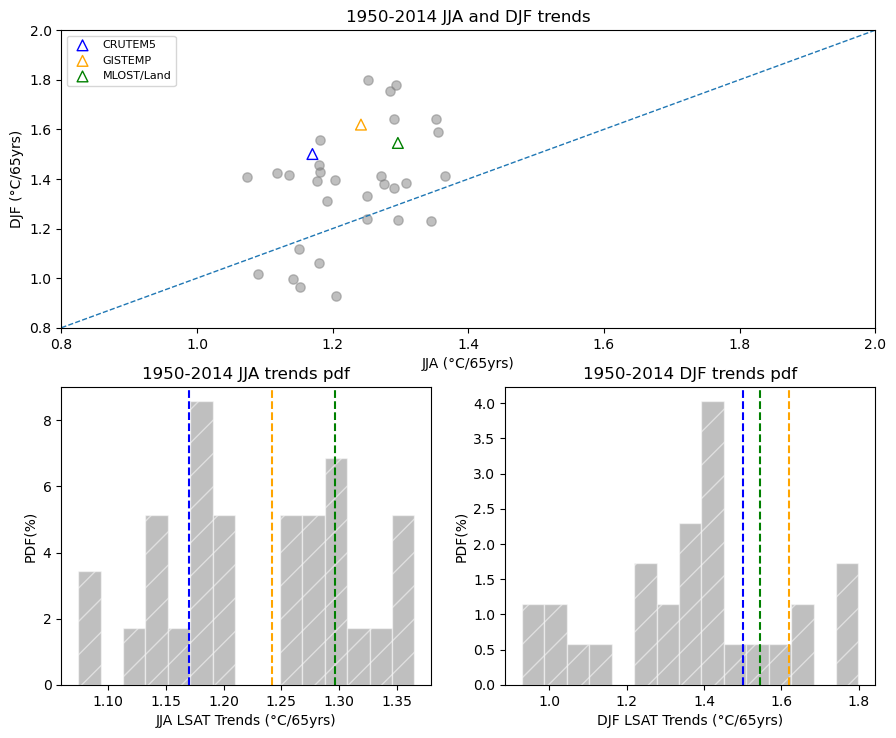

In [99]:
import seaborn as sns
# sns.set()

fig = plt.figure(figsize=(10.5, 8.5))  #layout="constrained"
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])

ax10 = fig.add_subplot(spec[1, 0])

ax11 = fig.add_subplot(spec[1, 1])

for i in np.arange(3,33):
    ax0.scatter(trend_output[1,i], trend_output[2,i], s=45, c='grey', marker='o',alpha=0.5)

ax0.set_title('1950-2014 JJA and DJF trends')
ax0.set_xlabel('JJA (°C/65yrs)')
ax0.set_ylabel('DJF (°C/65yrs)')
ax0.set_xlim(0.8, 2.0)
ax0.set_ylim(0.8, 2.0)
ax0.plot([0.8, 2.0], [0.8, 2.0], '--', lw=1)

ax0.scatter(trend_output[1,0], trend_output[2,0], s=60, marker='^', facecolors='none', edgecolors='blue', label='CRUTEM5')
ax0.scatter(trend_output[1,1], trend_output[2,1], s=60, marker='^', facecolors='none', edgecolors='orange', label='GISTEMP')
ax0.scatter(trend_output[1,2], trend_output[2,2], s=60, marker='^', facecolors='none', edgecolors='green', label='MLOST/Land')

ax0.legend(loc='upper left', fontsize=8)


ax10.set_title('1950-2014 JJA trends pdf')
ax10.set_xlabel('JJA LSAT Trends (°C/65yrs)')
ax10.set_ylabel('PDF(%)')
# Generate histogram
hist, bins = np.histogram(trend_output[1,3:], bins=30, density=True)

# Calculate PDF from histogram
bin_centers = 0.5 * (bins[1:] + bins[:-1])
pdf = hist / np.sum(hist)

# Plot the PDF
ax10.hist(trend_output[1,3:], bins=15, density=True, color='grey', alpha=0.5, hatch='/', edgecolor='white')
ax10.axvline(trend_output[1,0], color="blue", linestyle="--")
ax10.axvline(trend_output[1,1], color="orange", linestyle="--")
ax10.axvline(trend_output[1,2], color="green", linestyle="--")

ax11.set_title('1950-2014 DJF trends pdf')
ax11.set_xlabel('DJF LSAT Trends (°C/65yrs)')
ax11.set_ylabel('PDF(%)')
# Generate histogram
# hist, bins = np.histogram(trend_output[1,3:], bins=30, density=True)

# # Calculate PDF from histogram
# bin_centers = 0.5 * (bins[1:] + bins[:-1])
# pdf = hist / np.sum(hist)

# Plot the PDF
ax11.hist(trend_output[2,3:], bins=15, density=True, color='grey', alpha=0.5, hatch='/', edgecolor='white')
ax11.axvline(trend_output[2,0], color="blue", linestyle="--")
ax11.axvline(trend_output[2,1], color="orange", linestyle="--")
ax11.axvline(trend_output[2,2], color="green", linestyle="--")


plt.show()

In [94]:
fig.savefig("1950-2014-NH-LSAT-Trend-seasonal-changes.png")

In [204]:
fig.savefig("/work/mh0033/m301036/josie/LSAT/output-Figures/MPI-ESM-LR-NH_SATAs_15yr_running_trend.eps",format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [27]:
fig.savefig("/work/mh0033/m301036/josie/LSAT/output-Figures/MPI-ESM-LR-NH_SATAs_1900-2014.png",format='png')

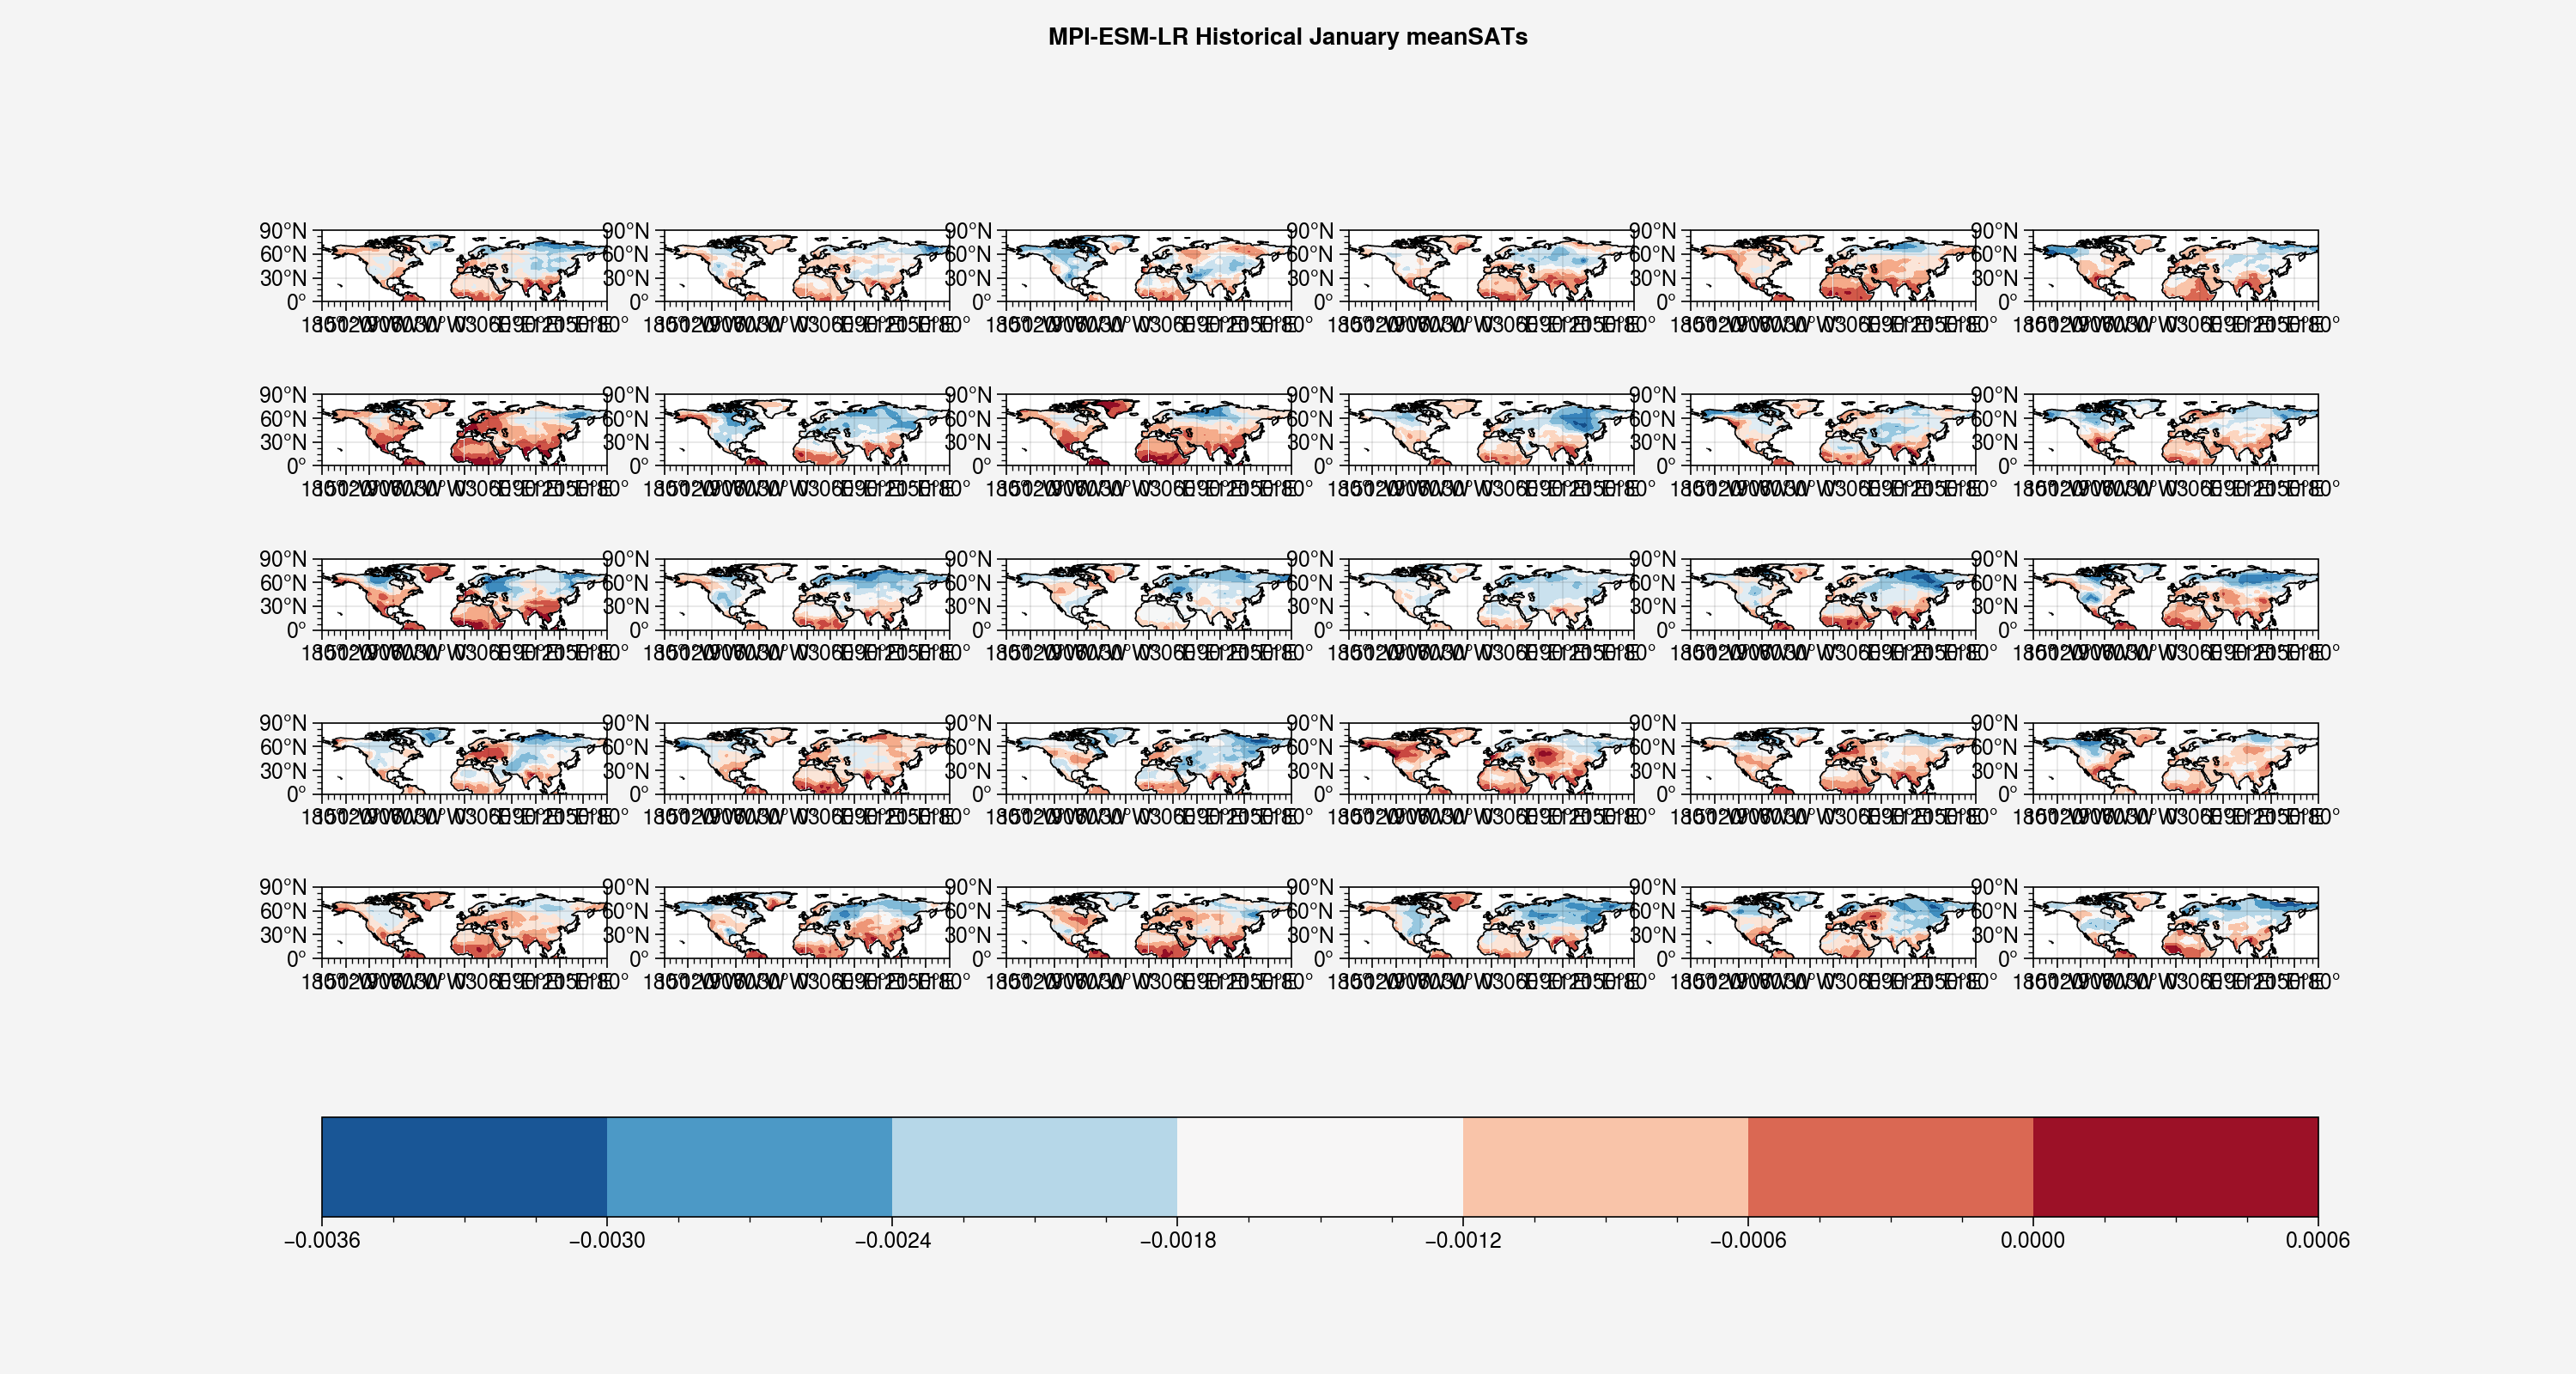

In [57]:

# import proplot as pplt
rows = 5
cols = 6

# create the figure and axes
projection = ccrs.PlateCarree()
fig, axs = plt.subplots(rows, cols, figsize=(15,8), subplot_kw={'projection':projection})
fig.suptitle('MPI-ESM-LR Historical January meanSATs')

# plot each model run
for i,ax in enumerate(axs.flat):
    mp=ax.contourf(lon, lat, annual_mean_anomalies[i, :, :], cmap='RdBu_r')#levels=np.arange(-30,30, 2.5)
    ax.set_xticks(np.arange(-180, 210, 30))#, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 120, 30))#, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
fig.colorbar(mp, ax=axs, orientation='horizontal', fraction=.1)
    
# add a legend and axis labels
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel('Model Output')
# display the figure
plt.show()
# images = []
# for i in range(Nr):
#     for j in range(Nc):
#         # Generate data with a range that varies from one plot to the next.
#         data = tas_ano()
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)